# Sex Classification using Periocular Images

---

*Note on the nomenclature in this project:*

*The word "sex" will be used throughout this project in place of the often incorrectly used "gender". Gender refers to characteristics assigned by cultural norms while sex are biological and physiologic characteristics.*

Need to think on this a bit more... If the model is picking up on certain periocular characteristics (applied makeup), an argument can be made for the use of the word gender here.

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
- 4.[**Exploratory Data Analysis (EDA)**](#eda)
  - 4.1. [Feature Scaling](#scaling)
  - 4.2. [PCA and t-SNE](#pca)
- 5.[**Models**](#models)
  - 5.1. [Baseline Models](#baseline)
- 6.[**Results**](#results)
- 7.[**Conclusion**](#conclusion)
  - 7.1. [Limitations](#limitations)
  - 7.2. [Future Work](#future)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


## 2. Setup <a name="setup"></a>

---

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

import sklearn
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score,classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

import tensorflow as tf
import torch
from torchvision.transforms import ToTensor
from facenet_pytorch import MTCNN, InceptionResnetV1




/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [ ]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns, kmodes, sklearn, xgb]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

### 2.2. Importing the Data: <a name="dataimport"></a>

In [2]:
def image_import(file_list, sex, image_size):
    '''
    Takes a list of image filenames and loads the images into a dictionary with the same filename(*).

    (*) Adds up to 4 leading zeros to the name if they are not present.
    
    Parameters:
        file_list: List of filenames in the form ['name.extension', ...]
        sex: String denoting the folder in ./data to find the images. ('Male' or 'Female')
        image_size: Integer, will all images resize to this parameter. 
            All images are different sizes, median/mean of dataset is 56x56.
    Returns:
        eyes_dict: Dictionary whose keys are the filename with leading zeros and value is a numpy array of the image.
    '''
    eyes_dict = {}
    # img_sizes = []
    for file in file_list:
        # Separate file extension and name.
        number, _ = file.split('.')
        number_new = number.zfill(4) # Add leading zeros.
        # Only take odd numbers to remove more than 1 eye per person.
        if int(number) % 2 == 1:
            img = Image.open(f'./Data/{sex}/{number}.jpg')
            # Used to check most common size.
            #img_sizes.append(np.asarray(img).shape[0])
            
            img = img.resize((image_size, image_size), Image.Resampling.LANCZOS)
            eyes_dict[number_new] = np.asarray(img).flatten()

    return eyes_dict #, image_sizes

In [3]:
img_size = 56 # Used throughout notebook.

female_files = os.listdir('./Data/Female')
male_files = os.listdir('./Data/male')

eyes_female = image_import(female_files, 'Female', image_size=img_size)
eyes_male = image_import(male_files, 'Male', image_size=img_size)

print('Number of Females:', len(eyes_female))
print('Number of Males:', len(eyes_male))

Number of Females: 2591
Number of Males: 3173


## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

(56, 56, 3)


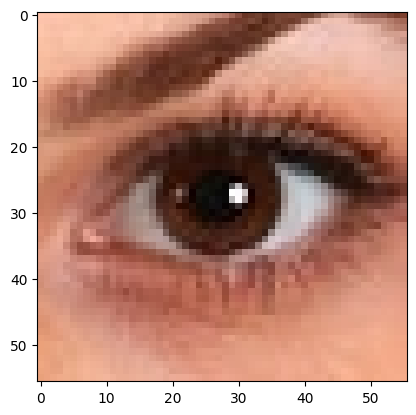

In [4]:
print(eyes_female['0011'].reshape(img_size,img_size,3).shape)
plt.imshow(Image.fromarray(eyes_female['0011'].reshape(img_size,img_size,3)))
plt.show()

The shape of `(56, 56, 3)` indicates an 3-dimensional array representing RGB with no alpha channel.

In [5]:
eyes_female_df = pd.DataFrame(eyes_female.items(), columns = ['eye_d', 'rgb_array'])
eyes_male_df = pd.DataFrame(eyes_male.items(), columns = ['eye_d', 'rgb_array'])

eyes_female_df['sex'] = 0
eyes_male_df['sex'] = 1

In [6]:
# Balance classes, limiting the number of male eyes.
eyes_male_df = eyes_male_df.sample(n = len(eyes_female_df), random_state = 11, replace = False)

# Create dataframe with mixed sexes.
eyes_df = pd.concat([eyes_female_df, eyes_male_df]).reset_index(drop = True)
eyes_df

,eye_d,rgb_array,sex
0,0823,"[216, 170, 136, 214, 168, 134, 212, 166, 133, ...",0
1,4217,"[141, 77, 49, 140, 76, 48, 138, 77, 48, 137, 7...",0
2,5109,"[244, 215, 199, 235, 206, 190, 165, 133, 118, ...",0
3,4571,"[237, 210, 193, 234, 207, 190, 234, 205, 189, ...",0
4,1409,"[175, 143, 130, 173, 141, 128, 172, 139, 130, ...",0
...,...,...,...
5177,0579,"[151, 112, 104, 149, 110, 103, 153, 114, 109, ...",1
5178,5191,"[210, 210, 210, 212, 212, 212, 209, 209, 209, ...",1
5179,0425,"[163, 118, 87, 164, 119, 88, 170, 125, 94, 166...",1
5180,5491,"[66, 44, 47, 48, 26, 30, 46, 25, 31, 44, 25, 3...",1


Normalize

In [7]:
eyes_df['norm_array'] = eyes_df['rgb_array'] / 255
# X_val['norm_array'] = X_val['rgb_array'] / 255
# X_test['norm_array'] = X_test['rgb_array'] / 255

## 4. Train / Val / Test Split <a name="split"></a>

---

Split 
- Train = 70%
- Validation = 18%
- Test = 12%

In [8]:
# Train and Test
X_train, X_test = train_test_split(eyes_df, test_size = 0.12, shuffle = True, stratify = eyes_df.sex, random_state = 11)
# Validation from Train
X_train, X_val = train_test_split(X_train, test_size = 0.18, shuffle = True, stratify = X_train.sex, random_state = 11)

# Create validation set.
# val_size = int(0.18 * len(X_train))
# X_val = X_train.iloc[-val_size: ]
# X_train = X_train.iloc[: -val_size]

# Create y.
y_train = X_train.sex
y_val = X_val.sex
y_test = X_test.sex

# Drop y from X.
X_train = X_train.drop(columns = ['sex'])
X_val = X_val.drop(columns = ['sex'])
X_test = X_test.drop(columns = ['sex'])

print(f'Train Set Size: {len(X_train)}')
print(f'Validation Set Size: {len(X_val)}')
print(f'Test Set Size: {len(X_test)}')

Train Set Size: 3739
Validation Set Size: 821
Test Set Size: 622


In [9]:
# Function to reshape arrays for models that require image array.
def df_reshape_array(flat_array):
    '''
    Takes a dataframe column (series) and reshapes flat array to image array (H x W x C).
    '''
    return flat_array.reshape(img_size,img_size,3)

X_train['norm_array_reshape'] = X_train.norm_array.apply(df_reshape_array)
X_val['norm_array_reshape'] = X_val.norm_array.apply(df_reshape_array)
X_test['norm_array_reshape'] = X_test.norm_array.apply(df_reshape_array)

## 5. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

Develop Image Transformation/Augmentation Function for training set.

(Random intensity, horizontal and vertical mirroring, rotations, subset crop of image + padding, etc)

Grayscale

In [10]:
def convert_to_grayscale(df):
    # Uses same method as PIL.
    # https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
    rgb_array_reshape = df.rgb_array.reshape(img_size,img_size,3)
    gray_array = np.dot(rgb_array_reshape, [0.2990, 0.5870, 0.1140])
    #gray_array_3_channel = np.concatenate((gray_array,)*3, axis = -1)
    return (gray_array.flatten())

# Convert all images and add grayscale arrays to dataframe.
X_train['gray_array'] = X_train.apply(convert_to_grayscale, axis = 1)

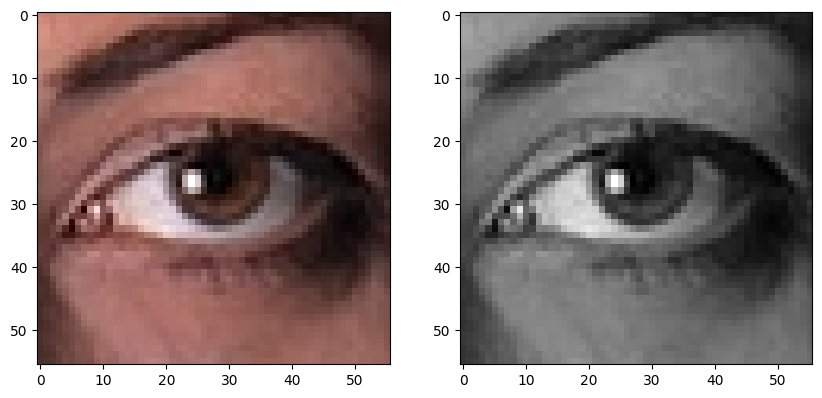

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (10,6))
ax[0].imshow(Image.fromarray(X_train.iloc[450].rgb_array.reshape(img_size,img_size,3)))
ax[1].imshow(Image.fromarray(X_train.iloc[450].gray_array.reshape(img_size,img_size)))
plt.show()

Develop texture maps and feature extractor filters

Check Week 2 Lecture 9 notes from DL/CV 5707 (Verma, Zisserman, A Statistical Approach to Texture Classification from Single Images)

## 6. Models <a name="models"></a>

---

### 6.1. Baseline Models: <a name="baseline"></a>

Random Chance Baseline

In [12]:
1/2

0.5

KNN as Baseline.

Since this dataset contains all eyes that are mostly centered in the same position, KNN is a quick and easy model to implement and compare more complex methods against.

In [13]:
# TODO: Implement KNN discriminant plot from sklearn.
mod_knn = KNeighborsClassifier(n_neighbors = 2, weights = 'distance', algorithm = 'brute', p = 2)
mod_knn.fit(np.stack(X_train.norm_array), y_train)

accuracy_score(mod_knn.predict(np.stack(X_val.norm_array)), y_val)
# results = classification_report(mod_knn.predict(np.stack(X_val.norm_array)), y_val, output_dict = True)
# pd.DataFrame().from_dict(results)

0.7649208282582217

SVM on Feature Vector

Shallow Tensorflow Feedforward Network (FFN)

In [16]:
model = tf.keras.Sequential()

model.add(tf.keras.Input(shape = X_train.norm_array.iloc[0].shape, name = 'Flattened Image'))
model.add(tf.keras.layers.Dense(512, activation = tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(128, activation = tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(2, name = 'Predictions'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     4,817,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Predictions (Dense)             │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,883,330 (18.63 MB)

 Trainable params: 4,883,330 (18.63 MB)

 Non-trainable params: 0 (0.00 B)

Model Specifications:

- Loss Function: Sparse Categorical using Cross-Entropy
- Optimizer: Adam
- Callbacks:
    - Early Stopping
    - Adjust Learning Rate on Loss Plateau

In [17]:
loss_fx = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # Integer labels.
optimizer_param = 'adam'
val_freq = 1
n_epochs = 150
# Callbacks to use:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 25, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                         factor = 0.5,
                                                         patience = 5,
                                                         cooldown = 8,
                                                         min_lr = 0.0001,
                                                         verbose = 1)

In [18]:
model.compile(optimizer = optimizer_param, loss = loss_fx, metrics = ['accuracy'])

mod_tf_seq = model.fit(
    x = np.stack(X_train.norm_array),
    y = y_train.to_numpy(),
    batch_size = None,
    epochs = n_epochs,
    verbose = "auto",
    callbacks = [early_stop, reduce_lr_plateau],
    validation_split = 0.0,
    validation_data = (np.stack(X_val.norm_array), y_val.to_numpy()),
    shuffle = True,
    class_weight = None,
    sample_weight = None,
    initial_epoch = 0,
    steps_per_epoch = None,
    validation_steps = None,
    validation_batch_size = None,
    validation_freq = val_freq)

Epoch 1/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5201 - loss: 2.6340 - val_accuracy: 0.7454 - val_loss: 0.5894 - learning_rate: 0.0010
Epoch 2/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6682 - loss: 0.6132 - val_accuracy: 0.7917 - val_loss: 0.4923 - learning_rate: 0.0010
Epoch 3/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7243 - loss: 0.5532 - val_accuracy: 0.8002 - val_loss: 0.4596 - learning_rate: 0.0010
Epoch 4/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7134 - loss: 0.5484 - val_accuracy: 0.8100 - val_loss: 0.4866 - learning_rate: 0.0010
Epoch 5/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7559 - loss: 0.5012 - val_accuracy: 0.6857 - val_loss: 0.5430 - learning_rate: 0.0010
Epoch 6/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7493 - loss: 0.5159 - val_accuracy: 0.8076 - val_loss: 0.4338 - learning_rate: 0.0010
Epoch 7/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7750 - l

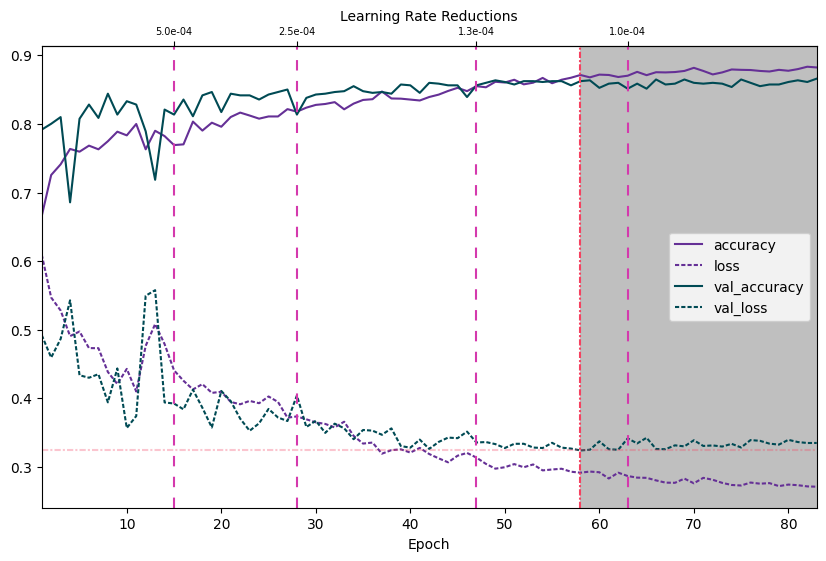

In [19]:
# Create dataframe of model fit history.
mod_tf_seq_df = pd.DataFrame().from_dict(mod_tf_seq.history, orient = 'columns')
mod_tf_seq_df.head()
# Find all epochs that callback ReduceLROnPlateau() occurred.
lr_change = mod_tf_seq_df.learning_rate.shift(-1) != mod_tf_seq_df.learning_rate

# Create color map and lines style map for train/val
plot_maps = {'cmap': {'accuracy': '#653096',
                    'loss': '#653096',
                    'val_accuracy': '#004a54',
                    'val_loss': '#004a54'},
            'dashmap': {'accuracy': '',
                        'loss': (2,1),
                        'val_accuracy': '',
                        'val_loss': (2,1)}}

# Plot
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.lineplot(mod_tf_seq_df.drop(columns = ['learning_rate']).iloc[1:], palette = plot_maps['cmap'], dashes = plot_maps['dashmap'])
ax.set_xlabel('Epoch')

# Create secondary x-axis for Learning Rate changes.
sec_ax = ax.secondary_xaxis('top')
sec_ax.set_xticks(mod_tf_seq_df[lr_change].index[:-1])
sec_ax.set_xticklabels([f'{x:.1e}' for x in mod_tf_seq_df[lr_change].learning_rate[1:]])
sec_ax.tick_params(axis = 'x', which = 'major', labelsize = 7)
sec_ax.set_xlabel('Learning Rate Reductions')

# Create vertical line for each LR change.
for epoch in (mod_tf_seq_df[lr_change].index[:-1]):
    plt.axvline(x = epoch, c = '#d439ad', ls = (0, (5,5)))
# Create lines for best epoch/val_loss.
plt.axvline(x = (mod_tf_seq_df.val_loss.idxmin()), c = '#f54260', ls = (0, (3,1,1,1)))
plt.axhline(y = (mod_tf_seq_df.val_loss.min()), c = '#f54260', alpha = 0.3, ls = (0, (3,1,1,1)))
# Grey out epochs after early stop.
plt.axvspan(mod_tf_seq_df.val_loss.idxmin(), mod_tf_seq_df.index.stop-1, facecolor = 'black', alpha = 0.25)
plt.margins(x = 0)
plt.legend()
plt.show()

In [20]:
y_pred_tf_seq_proba = model.predict(np.stack(X_val.norm_array), verbose = "auto", callbacks = None)
y_pred_tf_seq = y_pred_tf_seq_proba.argmax(axis = 1)

accuracy_score(y_pred_tf_seq, y_val)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.8623629719853837

In [15]:
# model.evaluate(
#     x=np.stack(X_val.norm_array.to_numpy()),
#     y=y_test.to_numpy(),
#     batch_size=None,
#     verbose="auto",
#     sample_weight=None,
#     steps=None,
#     callbacks=None,
#     return_dict=False
#     )

Deep Learning Model

Just playing around with Tensorflow CNNs here for now. Will move on to Pytorch with a more task specific architecture.

Padded+Dropout(after 2nd conv2d)+Dense(128):
64,5,5 | 2,2 | 32,5,5 | 2,2 | Dense(128) = 0.9269183922046285

3x3s:
32 (2,2,s=2) > 64 (2,2,s=2) > 256 dense = 0.925700365408039
32 (2,2,s=2) > 64 (2,2,s=2) > 256 dense > 256 dense = 0.9147381242387332
32 (2,2,s=2) > 64 (2,2,s=2) > 256 dense > drop 0.1 > 256 dense = 0.9001218026796589

16 (2,2,s=2) > 32 (2,2,s=2) > 1024 dense = 0.9171741778319124 (Shows some 93 potential)

3 Layers on 3nd conv:
16, 32, 1024 = 0.9269183922046285
16, 32, 512 == 0.9244823386114495
32, 64, 1024 = 0.9183922046285018

Talk about 5x5 vs 3x3 conv filters and how (with a stride of one) 2 3x3 = 1 5x5 but reduces parameters substantially.

In [219]:
mod_cnn = tf.keras.models.Sequential()
mod_cnn.add(tf.keras.Input(shape = (img_size,img_size,3), name = 'Image Array'))
mod_cnn.add(tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same'))
mod_cnn.add(tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same'))
mod_cnn.add(tf.keras.layers.MaxPooling2D((2,2), strides = 2))

mod_cnn.add(tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
mod_cnn.add(tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
mod_cnn.add(tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
mod_cnn.add(tf.keras.layers.MaxPooling2D((2,2), strides = 2))

mod_cnn.add(tf.keras.layers.Flatten())
mod_cnn.add(tf.keras.layers.Dense(1024))
mod_cnn.add(tf.keras.layers.Dense(2, name = 'Predictions'))
mod_cnn.summary()


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_160 (Conv2D)             │ (None, 56, 56, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 56, 56, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_162 (Conv2D)             │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_163 (Conv2D)             │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_164 (Conv2D)             │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1024)           │     6,423,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Predictions (Dense)             │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,451,506 (24.61 MB)

 Trainable params: 6,451,506 (24.61 MB)

 Non-trainable params: 0 (0.00 B)

In [220]:
loss_fx = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # Integer labels.
optimizer_param = 'adam'
val_freq = 1
n_epochs = 300
# Callbacks to use:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                         factor = 0.5,
                                                         patience = 5,
                                                         cooldown = 8,
                                                         min_lr = 0.0001,
                                                         verbose = 1)

In [221]:
mod_cnn.compile(loss=loss_fx,
                optimizer='sgd',
                metrics=['accuracy'])

mod_cnn_hist = mod_cnn.fit(np.stack(X_train.norm_array_reshape), y_train.to_numpy(),
                           batch_size = None,
                           epochs = n_epochs,
                           verbose = "auto",
                           callbacks = [early_stop, reduce_lr_plateau],
                           validation_split = 0.0,
                           validation_data = (np.stack(X_val.norm_array_reshape), y_val.to_numpy()),
                           shuffle = True,
                           class_weight = None,
                           sample_weight = None,
                           initial_epoch = 0,
                           steps_per_epoch = None,
                           validation_steps = None,
                           validation_batch_size = None,
                           validation_freq = val_freq)

Epoch 1/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5505 - loss: 0.6879 - val_accuracy: 0.6248 - val_loss: 0.6660 - learning_rate: 0.0100
Epoch 2/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6249 - loss: 0.6591 - val_accuracy: 0.7467 - val_loss: 0.6013 - learning_rate: 0.0100
Epoch 3/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6934 - loss: 0.5945 - val_accuracy: 0.7125 - val_loss: 0.5603 - learning_rate: 0.0100
Epoch 4/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7320 - loss: 0.5518 - val_accuracy: 0.8124 - val_loss: 0.4548 - learning_rate: 0.0100
Epoch 5/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7367 - loss: 0.5096 - val_accuracy: 0.8210 - val_loss: 0.4243 - learning_rate: 0.0100
Epoch 6/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7800 - loss: 0.4632 - val_accuracy: 0.7698 - val_loss: 0.4783 - learning_rate: 0.0100
Epoch 7/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7909 - l

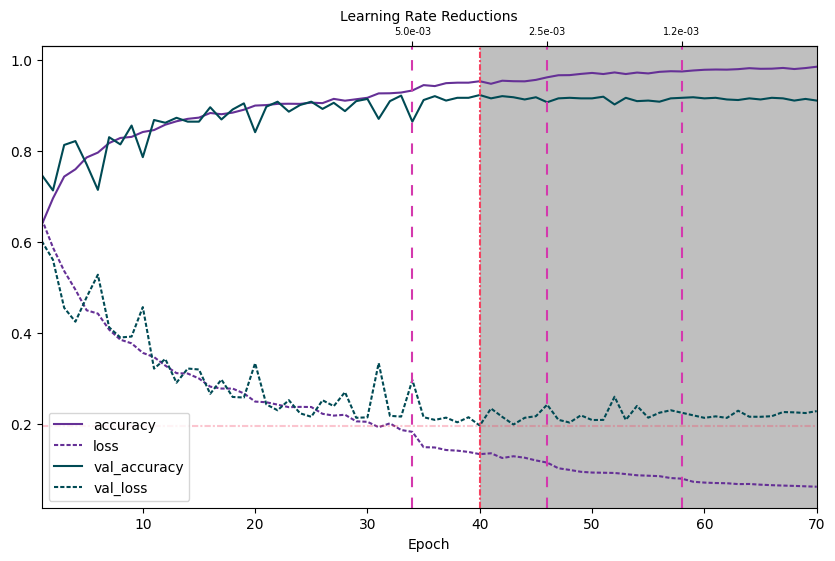

In [222]:
# Create dataframe of model fit history.
mod_cnn_hist_df = pd.DataFrame().from_dict(mod_cnn_hist.history, orient = 'columns')
mod_cnn_hist_df.head()
# Find all epochs that callback ReduceLROnPlateau() occurred.
lr_change = mod_cnn_hist_df.learning_rate.shift(-1) != mod_cnn_hist_df.learning_rate

# Create color map and lines style map for train/val
plot_maps = {'cmap': {'accuracy': '#653096',
                    'loss': '#653096',
                    'val_accuracy': '#004a54',
                    'val_loss': '#004a54'},
            'dashmap': {'accuracy': '',
                        'loss': (2,1),
                        'val_accuracy': '',
                        'val_loss': (2,1)}}

# Plot
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.lineplot(mod_cnn_hist_df.drop(columns = ['learning_rate']).iloc[1:], palette = plot_maps['cmap'], dashes = plot_maps['dashmap'])
ax.set_xlabel('Epoch')

# Create secondary x-axis for Learning Rate changes.
sec_ax = ax.secondary_xaxis('top')
sec_ax.set_xticks(mod_cnn_hist_df[lr_change].index[:-1])
sec_ax.set_xticklabels([f'{x:.1e}' for x in mod_cnn_hist_df[lr_change].learning_rate[1:]])
sec_ax.tick_params(axis = 'x', which = 'major', labelsize = 7)
sec_ax.set_xlabel('Learning Rate Reductions')

# Create vertical line for each LR change.
for epoch in (mod_cnn_hist_df[lr_change].index[:-1]):
    plt.axvline(x = epoch, c = '#d439ad', ls = (0, (5,5)))
# Create lines for best epoch/val_loss.
plt.axvline(x = (mod_cnn_hist_df.val_loss.idxmin()), c = '#f54260', ls = (0, (3,1,1,1)))
plt.axhline(y = (mod_cnn_hist_df.val_loss.min()), c = '#f54260', alpha = 0.3, ls = (0, (3,1,1,1)))
# Grey out epochs after early stop.
plt.axvspan(mod_cnn_hist_df.val_loss.idxmin(), mod_cnn_hist_df.index.stop-1, facecolor = 'black', alpha = 0.25)
plt.margins(x = 0)
plt.legend()
plt.show()

In [238]:
y_pred_cnn_proba = mod_cnn.predict(np.stack(X_val.norm_array_reshape), verbose = "auto", callbacks = None)
y_pred_cnn = y_pred_cnn_proba.argmax(axis = 1)

accuracy_score(y_pred_cnn, y_val)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


0.9220462850182704

In [323]:
# Get intermediate values from model.
# https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction
extractor = tf.keras.Model(inputs = mod_cnn.inputs,
                        outputs = [layer.output for layer in mod_cnn.layers])
features = extractor(np.stack(X_test.norm_array_reshape))

feature_vec_cnn = []
# Take feature vector from last fully connected layer.
for i in range(len(X_test)):
    feature_vec_cnn.append(features[8][i].numpy())

Extract deep learning embedding for PCA plot. Proof of concept with a pretrained face model.

To be continued.. Project has changed a bit since this was done -- will come back to this later when I build a DL CNN model.

In [161]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cpu


Visualize the resulting embeddings.

Explained Variance Ratios: [0.12188    0.09029462]


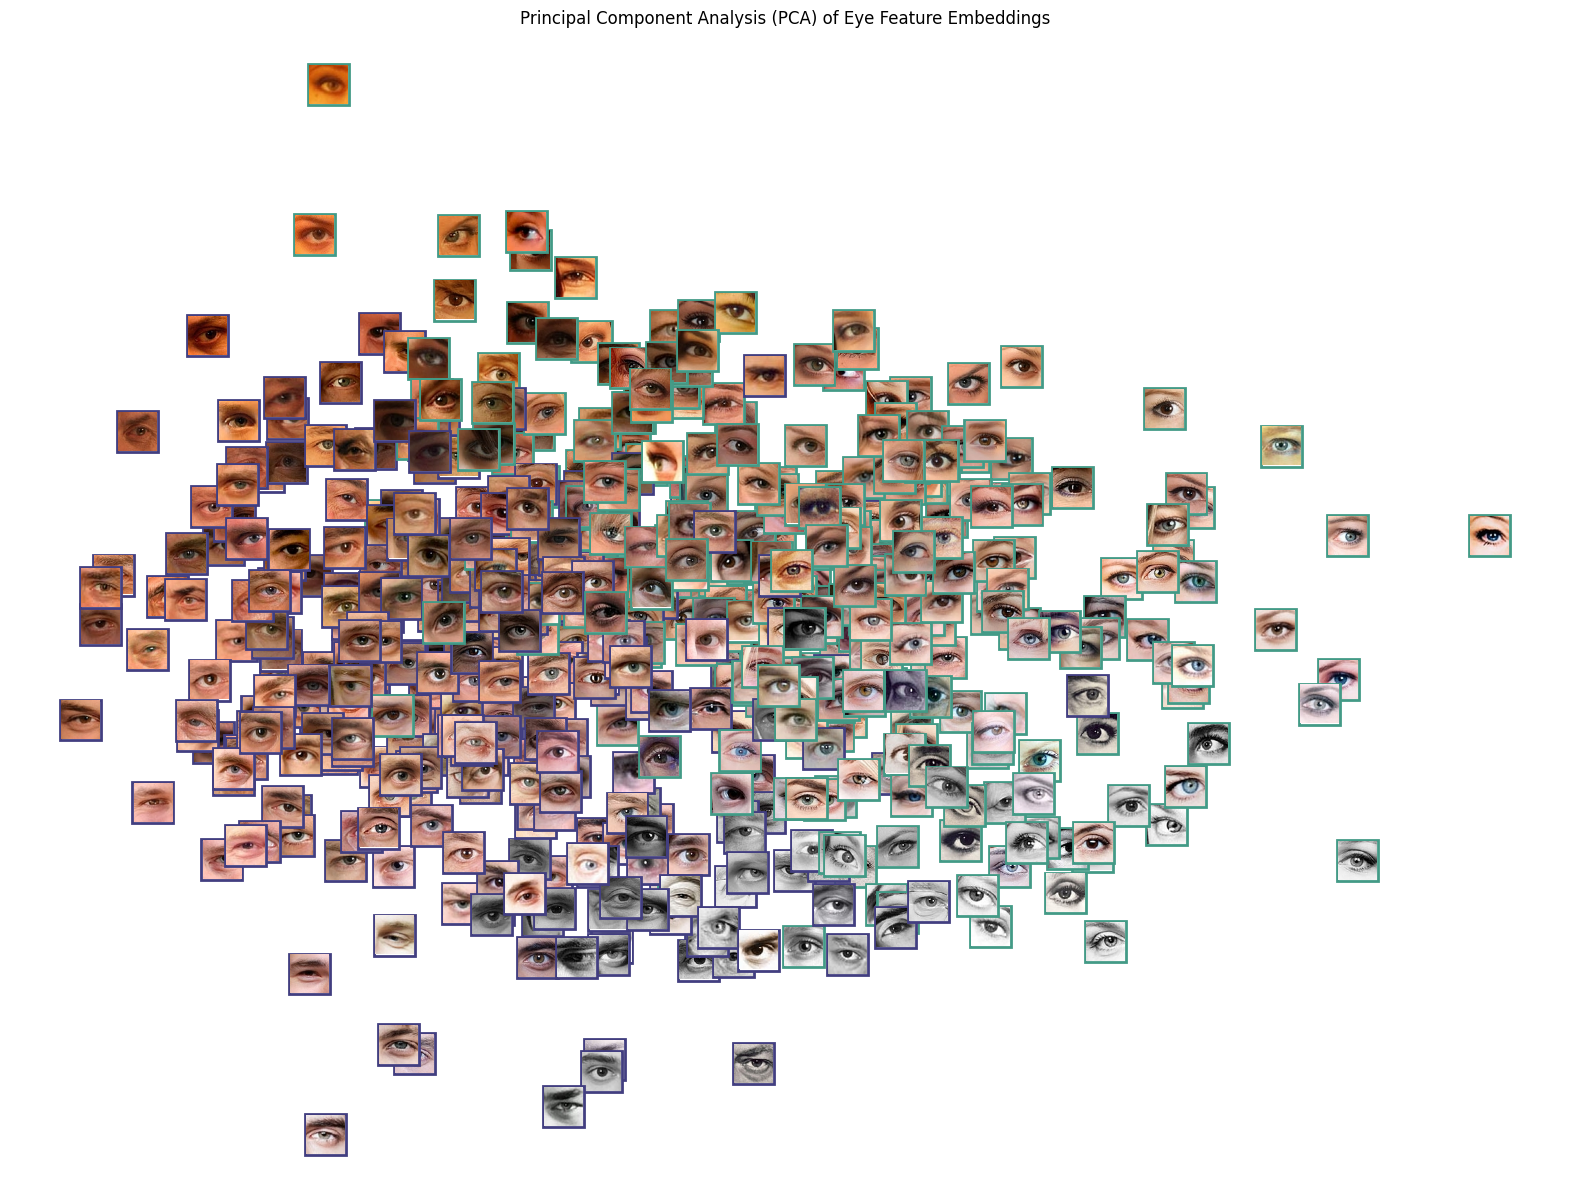

In [331]:
def pca_plot(features, image_arrays, zoom = 0.5, cmap = None, photos = True): #zoom = 0.125

    # Reduce dimensions to 2 using PCA.
    pca = PCA(n_components = 2)
    pca_fit = pca.fit_transform(features)
    print(f'Explained Variance Ratios: {pca.explained_variance_ratio_}')

    _, ax = plt.subplots(figsize = (20, 15), subplot_kw = {'aspect' : 'equal'})
    ax.scatter(pca_fit[:, 0], pca_fit[:, 1], c = cmap_sex, alpha = 0.8)
    
    # Add eye photos to plot.
    if photos == True:
        for i, rgb_array in enumerate(image_arrays):
            # Load image.
            image = Image.fromarray(rgb_array.reshape(img_size,img_size,3))
            # Zoom out.
            im = OffsetImage(image, zoom = zoom)
            # Set class label color for edge bbox.
            bboxprops = ({'edgecolor' : cmap[i], 'lw' : 2} if cmap is not None else None)
            anno_bbox = AnnotationBbox(offsetbox = im, 
                                xy = pca_fit[i],
                                xycoords = 'data',
                                frameon = (bboxprops is not None),
                                pad = 0.075,
                                bboxprops = bboxprops)
            ax.add_artist(anno_bbox)

    ax.set_axis_off()
    ax.axis('tight')
    ax.set_title('Principal Component Analysis (PCA) of Eye Feature Embeddings')

    return ax

# Teal = Women, Purple = Men
cmap_sex = ['#439A86' if sex == 0 else '#423e80' for sex in y_test]

# _ = pca_plot(X_train.embedding.tolist(), X_train.rgb_array.tolist(), cmap = cmap_sex)
# plt.show()
_ = pca_plot(feature_vec_cnn, X_test.rgb_array.tolist(), cmap = cmap_sex)
plt.show()

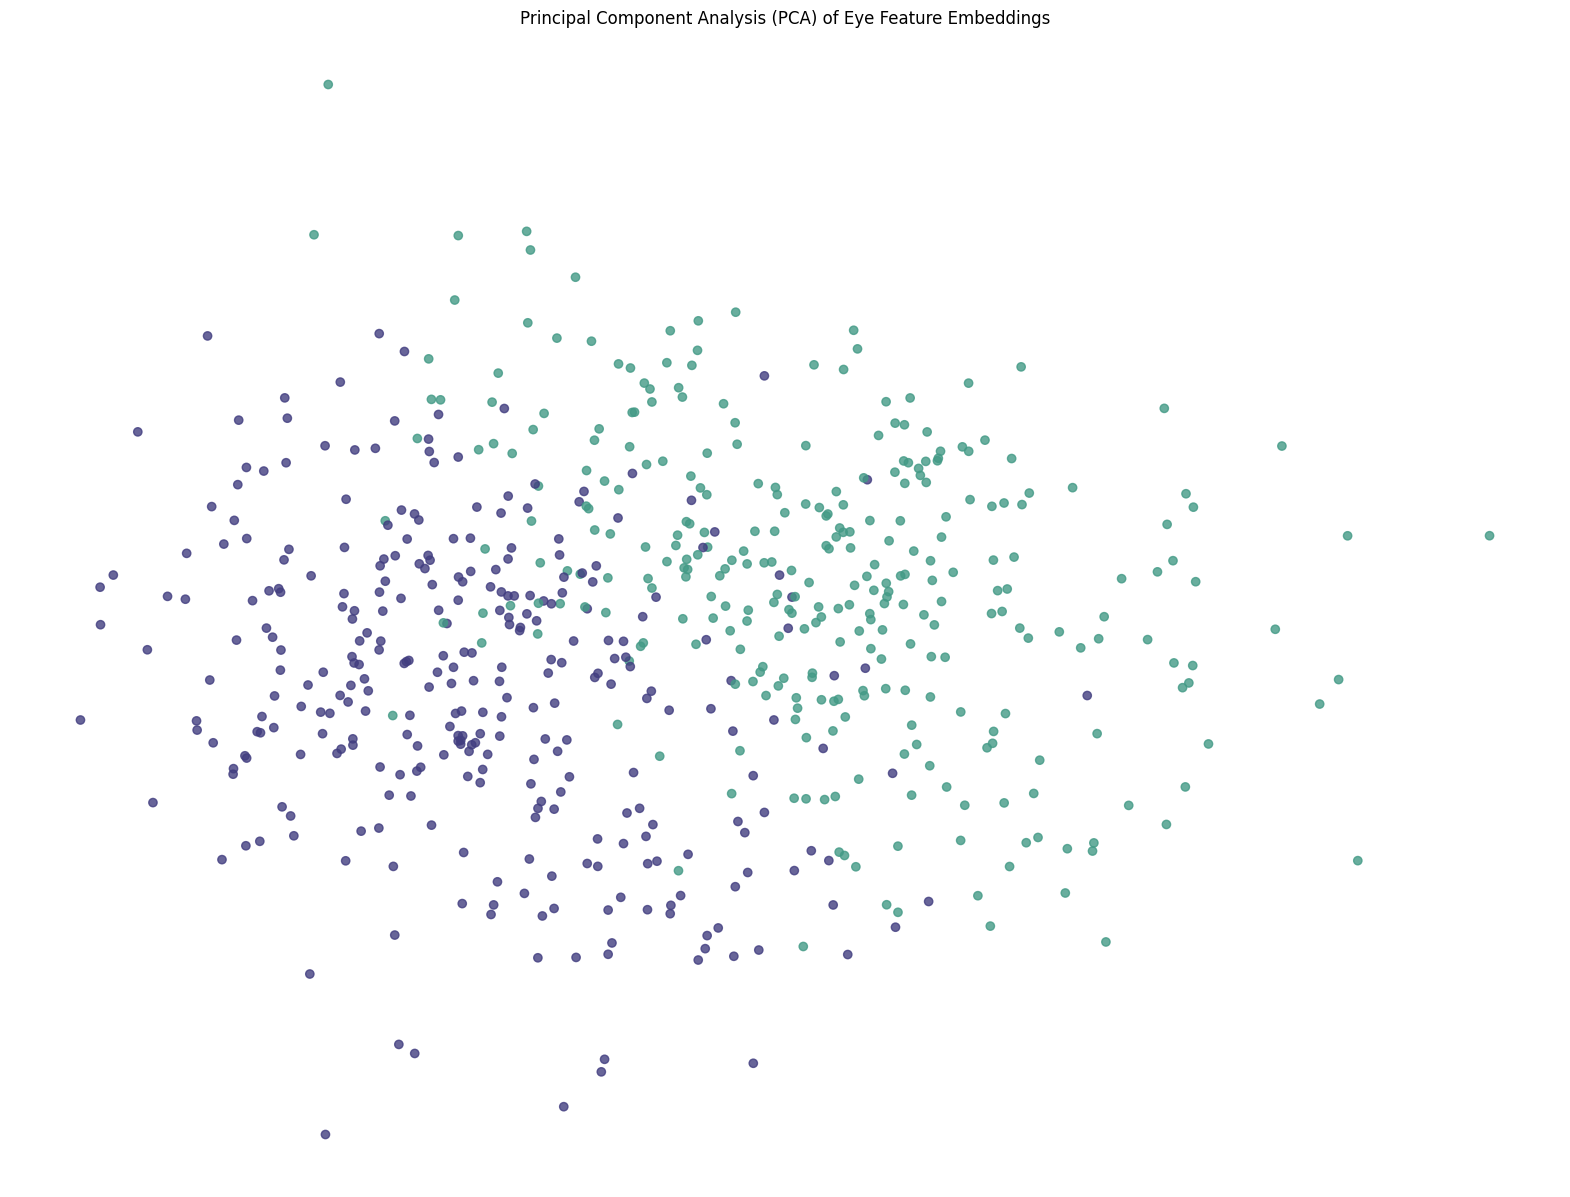

In [325]:
# _ = pca_plot(eyes_df.embedding.tolist(), eyes_df.rgb_array.tolist(), cmap = cmap_sex, photos = False)
# plt.show()
_ = pca_plot(feature_vec_cnn, X_test.rgb_array.tolist(), cmap = cmap_sex, photos = False)
plt.show()

## 7. Results <a name="results"></a>

---


## 8. Conclusion <a name="conclusion"></a>

---

### 8.1. Limitations: <a name="limitations"></a>

### 8.2. Future Work: <a name="future"></a>

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

1. 2016 paper iris sex classification based on in-depth feature selection and SVM: https://ieeexplore.ieee.org/abstract/document/7447785
2. 2018 paper iris sex classification based on Zernike moments and classifying using SVM and KNN: https://ieeexplore.ieee.org/document/8492757
3. 2019 paper iris .. using CNNs and image augmentation: https://ieeexplore.ieee.org/abstract/document/7447785
4. 2023 paper classifcation using periocular region and iris using pre-trained CNNs and transfer learning: https://www.sciencedirect.com/science/article/pii/S2666307423000268
5. 2019 Paper refuting previous papers claims on classifications based solely on iris; claiming periocular features were included: https://ieeexplore.ieee.org/document/8659186
6. Great examples of utilizing matplotlib to plot PCA/t-SNE tied to their images https://www.kaggle.com/code/hmendonca/proper-clustering-with-facenet-embeddings-eda
7. Local Binary Patterns used for feature extraction: https://en.wikipedia.org/wiki/Local_binary_patterns
8. Sobel filter edge detector: https://en.wikipedia.org/wiki/Sobel_operator

Alternative Datasets that would improve this project and allow for more nuanced segmentation of eye features:
1. Biometrics Research of Notre Dame has a high quality dataset. Behind a license application: https://cvrl.nd.edu/projects/data/
2. Another dataset with high-resolution iris photos. Behind license and too big for this project, though: https://ieee-dataport.org/documents/iris-super-resolution-dataset